# Importing the libraries

In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Getting and loading the Training and Testing set

In [2]:
path = r"C:\AI-DocHelper_Models_Code\IDC_Detection\dataset"

In [3]:
batch_size = 16
img_size = (50, 50)

In [4]:
image_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40.,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2, 
                                  horizontal_flip=True,
                                  fill_mode="nearest",
                                  validation_split=0.2)

In [5]:
train_generator = image_datagen.flow_from_directory(path,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode="binary",
                                                   subset="training",
                                                   shuffle=True)

validation_generator = image_datagen.flow_from_directory(path,
                                                        target_size=img_size,
                                                        batch_size=batch_size,
                                                        class_mode="binary",
                                                        subset="validation",
                                                        shuffle=False)

Found 60033 images belonging to 2 classes.
Found 15007 images belonging to 2 classes.


# Getting the class names

In [6]:
temp_classes = dict(train_generator.class_indices)

classes = dict()
for (k, v) in temp_classes.items():
    classes[v] = k
print(classes)

{0: '0', 1: '1'}


# Building the CNN

## Initalising the CNN

In [7]:
model = Sequential()

## Adding VGG16 as the model base

In [8]:
from tensorflow.keras.applications import VGG16

In [9]:
vgg16 = VGG16(input_shape=(img_size[0], img_size[1], 3),
             include_top = False,
             weights="imagenet")

In [10]:
for layer in vgg16.layers:
    layer.trainable= False

In [11]:
model.add(vgg16)

In [12]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

## Flattening all the layers

In [13]:
model.add(Flatten())

## Adding the First Fully Connected Layer

In [14]:
model.add(Dense(units=64, activation="relu"))

## Adding the Second Fully Connected Layer

In [15]:
model.add(Dense(units=32, activation="relu"))

## Adding the Third Fully Connected Layer

In [16]:
model.add(Dense(units=16, activation="relu"))

## Adding a Dropout layer

In [17]:
model.add(Dropout(rate=0.5))

## Adding the Final Fully Connected Layer

In [18]:
model.add(Dense(units=1, activation="sigmoid"))

## Diaplaying the model summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

# Compiling the CNN

In [20]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
              metrics=["accuracy"])

# Training the CNN

## Saving the best model only

In [21]:
checkpoint = ModelCheckpoint(filepath="idc.h5",
                            save_best_only=True)

## Stop the training, if there is no improvement

In [22]:
earlyStopping = EarlyStopping(monitor="val_loss",
                             patience=10,
                             restore_best_weights=True,
                             verbose=1)

## Calculating the steps_per_epoch and valiadtion_steps

In [23]:
import math

batch_size=batch_size
training_size = 60033 
validation_size = 15007

compute_steps_per_epoch = lambda x : int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(training_size)
valiadtion_steps = compute_steps_per_epoch(validation_size)

print(steps_per_epoch)
print(valiadtion_steps)

3753
938


In [24]:
history = model.fit(train_generator,
                   steps_per_epoch=steps_per_epoch,
                    epochs=30,
                   validation_data=validation_generator,
                   validation_steps=valiadtion_steps,
                   callbacks=[checkpoint, earlyStopping])

Epoch 1/30
3753/3753 [==============================] - 751s 200ms/step - loss: 0.5530 - accuracy: 0.7350 - val_loss: 0.4828 - val_accuracy: 0.7748
Epoch 2/30
3753/3753 [==============================] - 516s 138ms/step - loss: 0.4803 - accuracy: 0.7845 - val_loss: 0.5316 - val_accuracy: 0.7469
Epoch 3/30
3753/3753 [==============================] - 516s 138ms/step - loss: 0.4742 - accuracy: 0.7877 - val_loss: 0.4912 - val_accuracy: 0.7738
Epoch 4/30
3753/3753 [==============================] - 512s 136ms/step - loss: 0.4688 - accuracy: 0.7911 - val_loss: 0.4835 - val_accuracy: 0.7824
Epoch 5/30
3753/3753 [==============================] - 523s 139ms/step - loss: 0.4637 - accuracy: 0.7971 - val_loss: 0.5169 - val_accuracy: 0.7617
Epoch 6/30
3753/3753 [==============================] - 538s 143ms/step - loss: 0.4600 - accuracy: 0.7972 - val_loss: 0.5247 - val_accuracy: 0.7542
Epoch 7/30
3753/3753 [==============================] - 551s 147ms/step - loss: 0.4595 - accuracy: 0.7969 - val_

# Saving the model

In [25]:
model_json = model.to_json()

with open("idc.json", "w") as json_file :
    json_file.write(model_json)

# Visualizing the training performance

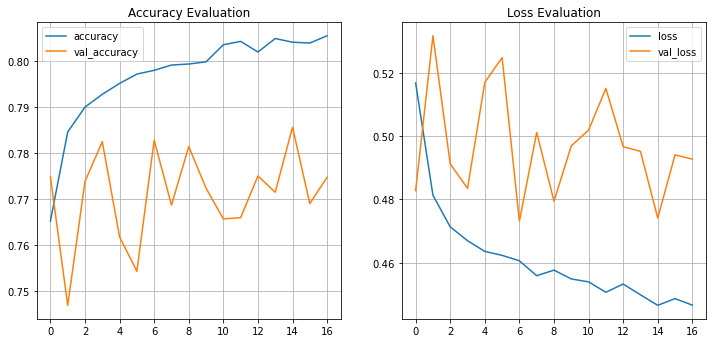

In [26]:
plt.figure(figsize = (12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.grid()
plt.title("Accuracy Evaluation")

plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.grid()
plt.legend()
plt.title("Loss Evaluation")

plt.savefig("idc_model_history.jpg")

# Getting the accuracy for test set

In [27]:
test_accuracy = model.evaluate(validation_generator)
print(test_accuracy)

938/938 [==============================] - 105s 112ms/step - loss: 0.4726 - accuracy: 0.7847
[0.4725691080093384, 0.7847004532814026]


In [28]:
preds = model.predict(validation_generator, verbose=1)
preds

938/938 [==============================] - 105s 112ms/step


array([[0.48149574],
       [0.5252784 ],
       [0.22043908],
       ...,
       [0.36122572],
       [0.35786685],
       [0.24245948]], dtype=float32)

In [29]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [30]:
print(predictions)

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
